<a href="https://colab.research.google.com/github/emmelinetsen/faceAI/blob/master/TFX_for_CNN_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Serve Model using TensorFlow Serving

Reference: https://colab.research.google.com/github/tensorflow/tfx/blob/master/docs/tutorials/serving/rest_simple.ipynb

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
!echo "deb http://storage.googleapis.com/tensorflow-serving-apt stable tensorflow-model-server tensorflow-model-server-universal" | tee /etc/apt/sources.list.d/tensorflow-serving.list && \
curl https://storage.googleapis.com/tensorflow-serving-apt/tensorflow-serving.release.pub.gpg | apt-key add -
!apt update


deb http://storage.googleapis.com/tensorflow-serving-apt stable tensorflow-model-server tensorflow-model-server-universal
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  2943  100  2943    0     0  20725      0 --:--:-- --:--:-- --:--:-- 20725
OK
Get:1 http://storage.googleapis.com/tensorflow-serving-apt stable InRelease [3,012 B]
Get:2 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran35/ InRelease [3,626 B]
Get:3 http://storage.googleapis.com/tensorflow-serving-apt stable/tensorflow-model-server-universal amd64 Packages [361 B]
Get:4 http://storage.googleapis.com/tensorflow-serving-apt stable/tensorflow-model-server amd64 Packages [354 B]
Hit:5 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease
Get:6 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Hit:7 http://archive.ubuntu.com/ubuntu bionic InRelease
Ign:8 https://develope

In [3]:
!apt-get install tensorflow-model-server


Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following NEW packages will be installed:
  tensorflow-model-server
0 upgraded, 1 newly installed, 0 to remove and 39 not upgraded.
Need to get 175 MB of archives.
After this operation, 0 B of additional disk space will be used.
Get:1 http://storage.googleapis.com/tensorflow-serving-apt stable/tensorflow-model-server amd64 tensorflow-model-server all 2.1.0 [175 MB]
Fetched 175 MB in 3s (68.8 MB/s)
Selecting previously unselected package tensorflow-model-server.
(Reading database ... 144433 files and directories currently installed.)
Preparing to unpack .../tensorflow-model-server_2.1.0_all.deb ...
Unpacking tensorflow-model-server (2.1.0) ...
Setting up tensorflow-model-server (2.1.0) ...


In [0]:
import sys

# Confirm that we're using Python 3
assert sys.version_info.major is 3, 'Oops, not running Python 3. Use Runtime > Change runtime type'

In [5]:
# TensorFlow and tf.keras
print("Installing dependencies for Colab environment")
!pip install -Uq grpcio==1.26.0

import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
import os
import subprocess

print('TensorFlow version: {}'.format(tf.__version__))

Installing dependencies for Colab environment
     |████████████████████████████████| 2.4MB 13.7MB/s 
TensorFlow version: 2.2.0


##TFX Serving

In [0]:
from tensorflow.keras.models import load_model
# loading CNN model for facial expression recognition
model = load_model('/content/drive/My Drive/CMPE 258 - Deep Learning/258_final_project/CNN_Model.h5') 

In [8]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 48, 48, 64)        1792      
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 48, 48, 64)        36928     
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 48, 48, 64)        36928     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 24, 24, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 24, 24, 64)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 24, 24, 64)        36928     
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 24, 24, 64)       

In [9]:
# Fetch the Keras session and save the model
# The signature definition is defined by the input and output tensors,
# and stored with the default serving key
import tempfile

MODEL_DIR = tempfile.gettempdir()
version = 1
export_path = os.path.join(MODEL_DIR, str(version))
print('export_path = {}\n'.format(export_path))

tf.keras.models.save_model(
    model,
    export_path,
    overwrite=True,
    include_optimizer=True,
    save_format=None,
    signatures=None,
    options=None
)

print('\nSaved model:')
!ls -l {export_path}

export_path = /tmp/1

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: /tmp/1/assets

Saved model:
total 304
drwxr-xr-x 2 root root   4096 May 16 22:58 assets
-rw-r--r-- 1 root root 302053 May 16 22:58 saved_model.pb
drwxr-xr-x 2 root root   4096 May 16 22:58 variables


In [10]:
!saved_model_cli show --dir {export_path} --all


MetaGraphDef with tag-set: 'serve' contains the following SignatureDefs:

signature_def['__saved_model_init_op']:
  The given SavedModel SignatureDef contains the following input(s):
  The given SavedModel SignatureDef contains the following output(s):
    outputs['__saved_model_init_op'] tensor_info:
        dtype: DT_INVALID
        shape: unknown_rank
        name: NoOp
  Method name is: 

signature_def['serving_default']:
  The given SavedModel SignatureDef contains the following input(s):
    inputs['conv2d_10_input'] tensor_info:
        dtype: DT_FLOAT
        shape: (-1, 48, 48, 3)
        name: serving_default_conv2d_10_input:0
  The given SavedModel SignatureDef contains the following output(s):
    outputs['dense_4'] tensor_info:
        dtype: DT_FLOAT
        shape: (-1, 8)
        name: StatefulPartitionedCall:0
  Method name is: tensorflow/serving/predict
W0516 22:58:55.186244 140008955139968 deprecation.py:506] From /usr/local/lib/python2.7/dist-packages/tensorflow_cor

In [0]:
os.environ["MODEL_DIR"] = MODEL_DIR

In [12]:
%%bash --bg 
nohup tensorflow_model_server \
  --rest_api_port=8501 \
  --model_name=cnn_model \
  --model_base_path="${MODEL_DIR}" >server.log 2>&1

Starting job # 0 in a separate thread.


In [13]:
!tail server.log

2020-05-16 22:59:01.151296: I external/org_tensorflow/tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 AVX512F FMA
2020-05-16 22:59:01.169707: I external/org_tensorflow/tensorflow/cc/saved_model/loader.cc:203] Restoring SavedModel bundle.
2020-05-16 22:59:01.214710: I external/org_tensorflow/tensorflow/cc/saved_model/loader.cc:152] Running initialization op on SavedModel bundle at path: /tmp/1
2020-05-16 22:59:01.225350: I external/org_tensorflow/tensorflow/cc/saved_model/loader.cc:333] SavedModel load for tags { serve }; Status: success: OK. Took 77725 microseconds.
2020-05-16 22:59:01.226805: I tensorflow_serving/servables/tensorflow/saved_model_warmup.cc:105] No warmup data file found at /tmp/1/assets.extra/tf_serving_warmup_requests
2020-05-16 22:59:01.226918: I tensorflow_serving/core/loader_harness.cc:87] Successfully loaded servable version {name: cnn_model version: 1}
2020-05-16 22:59:01.

'{"signature_name": "serving_default", "instances": [[[[167, 154, 146], [167, 155, 147], [167, 155, 145], [168, 158, 149], [168, 156, 149], [169, 157, 148], [168, 157, 150], [168, 157, 150], [170, 157, 150], [170, 159, 152], [170, 157, 148], [171, 156, 148], [177, 162, 151], [152, 136, 127], [156, 142, 138], [111, 98, 94], [113, 103, 101], [39, 31, 31], [115, 102, 95], [92, 85, 85], [57, 52, 60], [48, 40, 38], [53, 41, 38], [48, 39, 37], [60, 50, 48], [27, 21, 17], [39, 29, 27], [48, 37, 37], [88, 76, 74], [72, 59, 56], [32, 24, 23], [75, 64, 61], [117, 106, 101], [151, 138, 130], [182, 174, 165], [175, 163, 152], [172, 161, 152], [170, 159, 150], [169, 158, 150], [169, 158, 150], [168, 156, 148], [169, 157, 149], [167, 156, 148], [167, 155, 147], [166, 155, 147], [166, 155, 147], [166, 154, 145], [165, 153, 143]], [[169, 156, 148], [167, 156, 149], [169, 158, 150], [169, 159, 152], [169, 159, 152], [170, 159, 151], [170, 158, 151], [172, 159, 150], [168, 158, 152], [171, 159, 151], [1

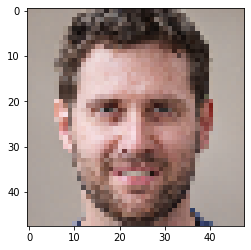

In [50]:
from keras.preprocessing import image
import json

# using images created from GAN for testing the model serving on TFX
img1 = image.load_img("/content/drive/My Drive/CMPE 258 - Deep Learning/258_final_project/data/stylegan2/image2.png",target_size=(48,48))
img1 = np.asarray(img1)
plt.imshow(img1)
img1 = np.expand_dims(img1, axis=0)

data = json.dumps({"signature_name": "serving_default", "instances": img1.tolist()})
data

In [0]:
!pip install -q requests

import requests
headers = {"content-type": "application/json"}
json_response = requests.post('http://localhost:8501/v1/models/cnn_model:predict', data=data, headers=headers)
predictions = json.loads(json_response.text)['predictions']
output = predictions[0]

[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0]


'fear'

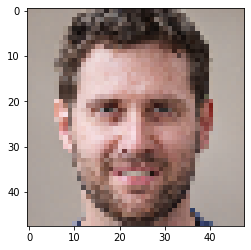

In [52]:
from keras.preprocessing import image

classes = ['angry','disgust','fear','happy','sad','surprise','neutral','embarrassed']

img = image.load_img("/content/drive/My Drive/CMPE 258 - Deep Learning/258_final_project/data/stylegan2/image2.png",target_size=(48,48))
img = np.asarray(img)
plt.imshow(img)
img = np.expand_dims(img, axis=0)

print(output)
classes[np.argmax(output)]